This a similar analysis to the other files except the outcome is binarized by median split


In [5]:
# Connects to your Google Drive so you can import files
from google.colab import drive
drive.mount('/content/drive')

import numpy as np # linear algebra
import pandas as pd

file_path = '/content/drive/My Drive/Colab Notebooks/PC_ROST.csv'
data = pd.read_csv(file_path)
data.sample(4)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC74,PC75,PC76,PC77,PC78,PC79,PC80,PC81,PC82,binary_score
63,-13.333433,-1.873393,-5.054638,-2.886837,1.387492,2.222041,0.724203,0.451485,2.463927,-0.105515,...,0.547180,-0.885435,-0.352160,-1.120807,-0.513659,-0.018441,-0.437511,0.412799,-0.416162,0
21,4.473739,2.904523,2.461669,-0.379736,0.693339,2.070385,2.907722,1.729358,-0.936097,1.057986,...,-1.092207,-0.025604,1.010742,0.337220,-1.149743,-0.260771,-0.291649,-0.974312,0.095778,1
71,-0.287892,4.993487,3.102034,-2.222342,-0.636503,1.516610,1.170943,0.648752,-2.341034,-0.692762,...,0.166100,0.268898,0.637132,0.659079,1.131999,0.736716,0.880871,-0.152645,-0.031954,1
69,4.370848,-1.722403,-0.759767,1.279214,-0.438272,-0.713162,2.274586,-0.097561,1.345628,-0.450775,...,-0.296067,0.525923,0.088150,0.458874,-0.937114,0.462813,-0.395600,0.176080,-0.115572,1


In [6]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Separate features and target
X = data.drop('binary_score', axis=1)
y = data['binary_score']

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features (important for neural networks)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [7]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.regularizers import l1

# Define the model
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],), kernel_regularizer=l1(0.5)),
    Dense(64, activation='relu', kernel_regularizer=l1(0.5)),
    Dense(64, activation='relu', kernel_regularizer=l1(0.5)),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [8]:
from tensorflow.keras.callbacks import EarlyStopping

# Setting up EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=10, verbose=1, mode='min', restore_best_weights=True)

from tensorflow.keras.callbacks import ReduceLROnPlateau

# Initialize the callback
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, min_lr=0.00001, verbose=1)

# Fit the model with the callback
history = model.fit(X_train_scaled, y_train, epochs=100, validation_split=0.1, callbacks=[reduce_lr,early_stopping])

Epoch 1/100
2/2 [==============================] - 1s 265ms/step - loss: 701.6243 - accuracy: 0.5714 - val_loss: 691.5615 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 2/100
2/2 [==============================] - 0s 37ms/step - loss: 688.3010 - accuracy: 0.5556 - val_loss: 678.3422 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 3/100
2/2 [==============================] - 0s 32ms/step - loss: 675.1188 - accuracy: 0.5397 - val_loss: 665.2582 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 4/100
2/2 [==============================] - 0s 37ms/step - loss: 662.0668 - accuracy: 0.5714 - val_loss: 652.2972 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 5/100
2/2 [==============================] - 0s 32ms/step - loss: 649.1447 - accuracy: 0.5556 - val_loss: 639.4868 - val_accuracy: 0.6250 - lr: 0.0010
Epoch 6/100
2/2 [==============================] - 0s 33ms/step - loss: 636.3719 - accuracy: 0.5397 - val_loss: 626.8300 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 7/100
2/2 [==============================] - 0s 32m

In [9]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test_scaled, y_test)
print(f'Test Accuracy: {accuracy*100:.2f}%')


1/1 [==============================] - 0s 36ms/step - loss: 5.3551 - accuracy: 0.6111
Test Accuracy: 61.11%


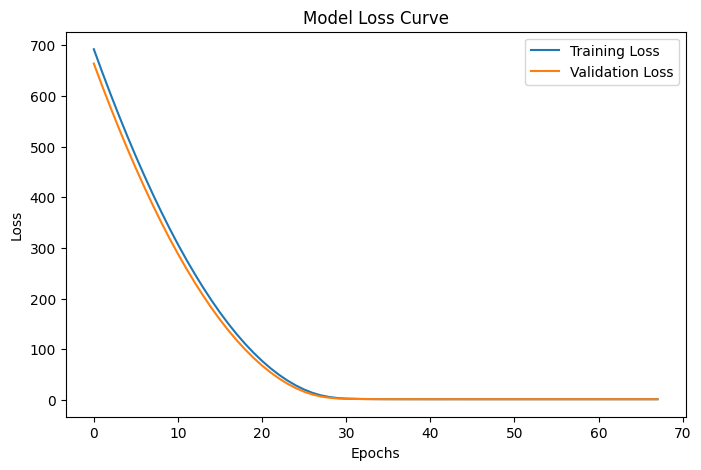

In [ ]:
import matplotlib.pyplot as plt

# Assume 'history' is the output from the 'fit' method
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Curve')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()
plt.show()


1/1 [==============================] - 0s 165ms/step


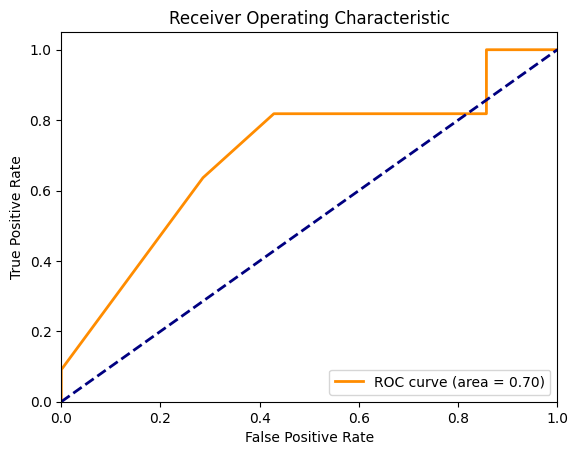

In [10]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Assuming 'X_test_scaled' is your preprocessed test set
# Get model predictions as probabilities
y_scores = model.predict(X_test_scaled).ravel()  # .ravel() flattens the array if needed

# 'y_test' should be your actual labels

fpr, tpr, thresholds = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

